# Scenario 1

All validators offer the same commission, delegators look for best yield.

*Prediction: low-stake, high-engagement validators benefit the most over time, but all do worse with delegation than without.*

In [1]:
from cadCAD import configs
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionContext, ExecutionMode, Executor
import copy
import math
import matplotlib.pyplot as plt
import random
import statistics
%matplotlib inline

## Parameters

## Helper functions

In [2]:
def calculate_gini_coefficient(voting_weights):
    """A measure of inequality. 0 is total equality, 1 is total inequality."""
    numerator = sum([sum([abs(i - j) for j in voting_weights]) for i in voting_weights])
    
    n = len(voting_weights)
    x_bar = statistics.mean(voting_weights)
    denominator = 2 * n**2 * x_bar
    
    return numerator / denominator

In [3]:
def default_sigmoidal(stake, engagement):
    return 2000 / (1 + math.exp(-0.000001 * (stake * engagement)**0.68)) - 1000

In [4]:
def calculate_voting_weight(validator, f):
    self_stake = validator['self_stake']
    delegation = validator['delegation']
    engagement = validator['engagement']

    return f(self_stake + delegation, engagement)

In [5]:
def calculate_total_voting_weight(validators, f):
    return sum([calculate_voting_weight(validator, f) for validator in validators])

In [6]:
def calculate_reward(validator, total_voting_weight, inflation_rate, f):
    self_stake = validator['self_stake']
    engagement = validator['engagement']
    commission_rate = validator['commission_rate']

    voting_weight = calculate_voting_weight(validator, f)
    self_stake_voting_weight = f(self_stake, engagement)

    return inflation_rate * (self_stake_voting_weight + commission_rate * (voting_weight - self_stake_voting_weight)) / total_voting_weight

In [7]:
def calculate_yield(validator, total_voting_weight, inflation_rate, f):
    commission_rate = validator['commission_rate']
    self_stake = validator['self_stake']
    engagement = validator['engagement']
    delegation = validator['delegation']

    if delegation == 0:
        return 0
    
    voting_weight = calculate_voting_weight(validator, f)

    return (inflation_rate * (1 - commission_rate) * (voting_weight - f(self_stake, engagement))) / (delegation * total_voting_weight)

In [8]:
def create_validator(i, commission_rate, self_stake_base, self_stake_max, engagement_base, engagement_max, delegation = 0):
    self_stake = self_stake_max * self_stake_base**i
    engagement = engagement_max * engagement_base**i
    return {
        'commission_rate': commission_rate,
        'self_stake': self_stake,
        'engagement': engagement,
        'delegation': delegation, # redundant state (can be calculated from state of delegators)
    }

In [9]:
def create_delegator(delegation, validator_index = None):
    return {
        'delegation': delegation,
        'validator': validator_index,
    }

In [10]:
def hypothesize_yield(delegator, validator_index, validators, inflation_rate, f):
    current_validator_index = delegator['validator']
    delegation = delegator['delegation']
    
    if current_validator_index == validator_index:
        total_voting_weight = calculate_total_voting_weight(validators, f)
        return calculate_yield(validators[current_validator_index], total_voting_weight, inflation_rate, f)
    
    if current_validator_index != None:
        validators[current_validator_index]['delegation'] -= delegation
    
    next_validator = validators[validator_index]
    next_validator['delegation'] += delegation
    total_voting_weight = calculate_total_voting_weight(validators, f)
    
    return calculate_yield(next_validator, total_voting_weight, inflation_rate, f)

## Model

In [11]:
# network parameters
default_inflation_rate = 1_000_000

# validator parameters
n_validators = 20
default_commission_rate = 0.2
self_stake_base = 0.7
self_stake_max = 4_000_000
fixed_cost = 10_000
engagement_base = 0.7
engagement_max = 10_000
default_f = default_sigmoidal

# delegator parameters
n_delegators = 1000
delegation_stake_multiple = 3
default_delegation_rate = 0.1
default_delegation_threshold = 0.03
default_redelegation_threshold = 0.005

# simulation parameters
n_timesteps = 50
n_runs = 1

In [12]:
validators = [create_validator(
    i,
    default_commission_rate,
    self_stake_base,
    self_stake_max,
    engagement_base,
    engagement_max,
) for i in range(n_validators)]
validators.reverse()

engagements = [validator['engagement'] for validator in validators]
random.shuffle(engagements)
for i, validator in enumerate(validators):
    validator['engagement'] = engagements[i]

validators_pre = copy.deepcopy(validators)

In [13]:
sum_validators_self_stake = sum([validator['self_stake'] for validator in validators])
delegation = delegation_stake_multiple * sum_validators_self_stake / n_delegators
delegators = [create_delegator(delegation) for _ in range(n_delegators)]

In [14]:
initial_state = {
    'delegators': delegators,
    'validators': validators,
}

In [15]:
def should_redelegate(delegator, validators, hypothetical_yield, delegation_rate, delegation_threshold, redelegation_threshold, inflation_rate, f):
    current_validator_index = delegator['validator']
    if random.random() >= delegation_rate:
        return False
    if current_validator_index is None:
        return hypothetical_yield >= delegation_threshold
    
    total_voting_weight = calculate_total_voting_weight(validators, f)
    current_yield = calculate_yield(validators[current_validator_index], total_voting_weight, inflation_rate, f)
    return hypothetical_yield >= redelegation_threshold + current_yield

In [16]:
def redelegate(params, step, history, current_state):
    inflation_rate = params['inflation_rate']
    delegation_rate = params['delegation_rate']
    delegation_threshold = params['delegation_threshold']
    redelegation_threshold = params['redelegation_threshold']
    f = params['f']
    delegators = copy.deepcopy(current_state['delegators'])
    validators = copy.deepcopy(current_state['validators'])
    
    hypothetical_yields_all = [
        [
            hypothesize_yield(delegator, i, copy.deepcopy(validators), inflation_rate, f) for i in range(len(validators))
        ] for delegator in delegators
    ]
    max_hypothetical_yields_all = [max(hypothetical_yields) for hypothetical_yields in hypothetical_yields_all]
    max_validator_indices_all = [
        [
            i for i, hypothetical_yield in enumerate(hypothetical_yields) if hypothetical_yield == max_hypothetical_yield
        ] for hypothetical_yields, max_hypothetical_yield in zip(hypothetical_yields_all, max_hypothetical_yields_all)
    ]
    max_validator_indices = [random.choice(max_validator_indices) for max_validator_indices in max_validator_indices_all]
    validator_indices = [
        max_validator_index
            if should_redelegate(delegator, validators, max_hypothetical_yield, delegation_rate, delegation_threshold, redelegation_threshold, inflation_rate, f)
            else delegator['validator']
        for delegator, max_validator_index, max_hypothetical_yield in zip(delegators, max_validator_indices, max_hypothetical_yields_all)
    ]

    return {
        'type': 'redelegate',
        'validator_indices': validator_indices,
    }

In [17]:
def update_delegators(params, step, history, current_state, action):
    delegators = copy.deepcopy(current_state['delegators'])
    validator_indices = action['validator_indices']
    
    if action['type'] != 'redelegate':
        return 'delegators', delegators
    
    for i, delegator in enumerate(delegators):
        delegator['validator'] = validator_indices[i]
        
    return 'delegators', delegators

In [18]:
def update_validators(params, step, history, current_state, action):
    inflation_rate = params['inflation_rate']
    delegators = copy.deepcopy(current_state['delegators'])
    validators = copy.deepcopy(current_state['validators'])
    validator_indices = action['validator_indices']
    
    if action['type'] != 'redelegate':
        return 'validators', validators
    
    for i, validator in enumerate(validators):
        self_stake = validator['self_stake']
        engagement = validator['engagement']
        delegators_for_validator = [delegator for j, delegator in zip(validator_indices, delegators) if i == j]
        delegation = sum([delegator['delegation'] for delegator in delegators_for_validator])
        validator['delegation'] = delegation
    
    return 'validators', validators

## Simulation

In [19]:
partial_state_update_blocks = [
    {
        'policies': {
            'redelegate': redelegate,
        },
        'variables': {
            'delegators': update_delegators,
            'validators': update_validators,
        },
    },
]

In [20]:
parameters = {
    'inflation_rate': [default_inflation_rate],
    'delegation_rate': [default_delegation_rate],
    'delegation_threshold': [default_delegation_threshold],
    'redelegation_threshold': [default_redelegation_threshold],
    'f': [default_f],
}

simulation_config = config_sim({
    'T': range(n_timesteps),
    'N': n_runs,
    'M': parameters,
})

In [21]:
experiment = Experiment()
experiment.append_configs(
    sim_configs=simulation_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

execution_mode = ExecutionMode()
execution_context = ExecutionContext(execution_mode.local_mode)
executor = Executor(execution_context, configs)

In [22]:
raw_result, _, __ = executor.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (50, 5, 1, 2)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 115.98s


## Analysis

In [23]:
validators_result = [result['validators'] for result in raw_result]
voting_weights = [[calculate_voting_weight(validators[i], default_f) for validators in validators_result] for i in range(n_validators)]
delegations = [[validators[i]['delegation'] for validators in validators_result] for i in range(n_validators)]

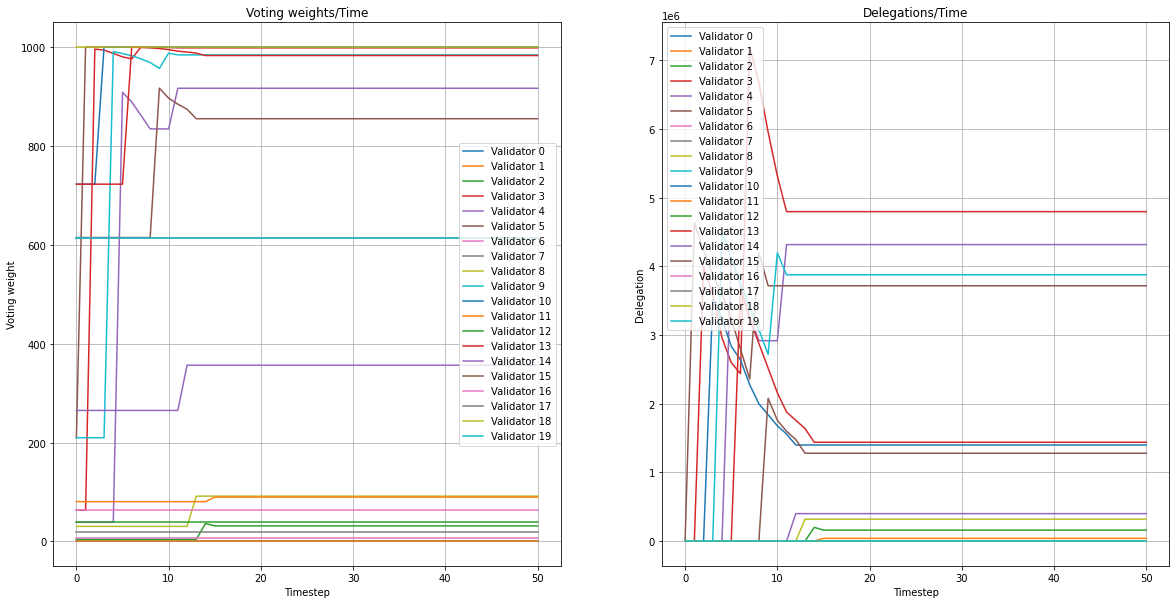

In [24]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('Voting weights/Time')
plt.xlabel('Timestep')
plt.ylabel('Voting weight')
for i, voting_weight in enumerate(voting_weights):
    plt.plot(voting_weight, label=(f"Validator %i" % i))
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Delegations/Time')
plt.xlabel('Timestep')
plt.ylabel('Delegation')
for i, delegation in enumerate(delegations):
    plt.plot(delegation, label=(f"Validator %i" % i))
plt.grid()
plt.legend()

plt.show()

In [25]:
validators_post = raw_result[-1]['validators']

voting_weights_pre = [calculate_voting_weight(validator, default_f) for validator in validators_pre]
voting_weights_post = [calculate_voting_weight(validator, default_f) for validator in validators_post]

total_voting_weight_pre = sum(voting_weights_pre)
total_voting_weight_post = sum(voting_weights_post)

profits_pre = [calculate_reward(validator, total_voting_weight_pre, default_inflation_rate, default_f) - fixed_cost for validator in validators_pre]
profits_post = [calculate_reward(validator, total_voting_weight_post, default_inflation_rate, default_f) - fixed_cost for validator in validators_post]

In [26]:
default_alt_color = "#ff7f0e"

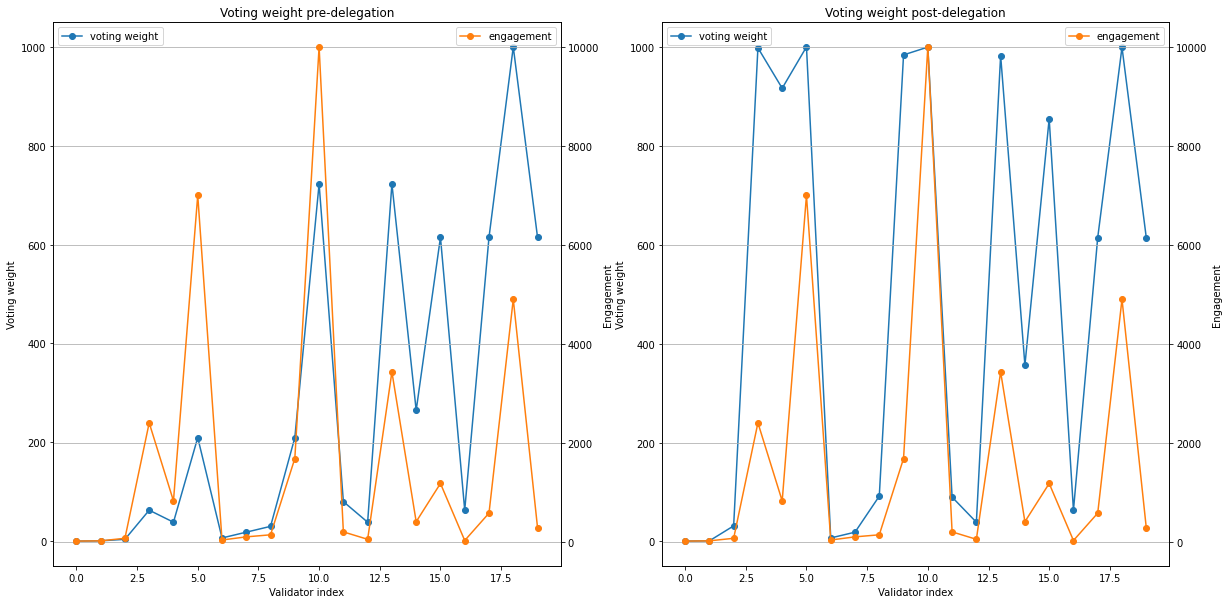

In [27]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('Voting weight pre-delegation')
plt.xlabel('Validator index')
plt.ylabel('Voting weight')
plt.plot(voting_weights_pre, marker='o', label="voting weight")
plt.legend(loc=2)
plt.twinx()
plt.ylabel('Engagement')
plt.plot(engagements, marker='o', color=default_alt_color, label="engagement")
plt.legend(loc=0)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Voting weight post-delegation')
plt.xlabel('Validator index')
plt.ylabel('Voting weight')
plt.plot(voting_weights_post, marker='o', label="voting weight")
plt.legend(loc=2)
plt.twinx()
plt.ylabel('Engagement')
plt.plot(engagements, marker='o', color=default_alt_color, label="engagement")
plt.legend()
plt.grid()

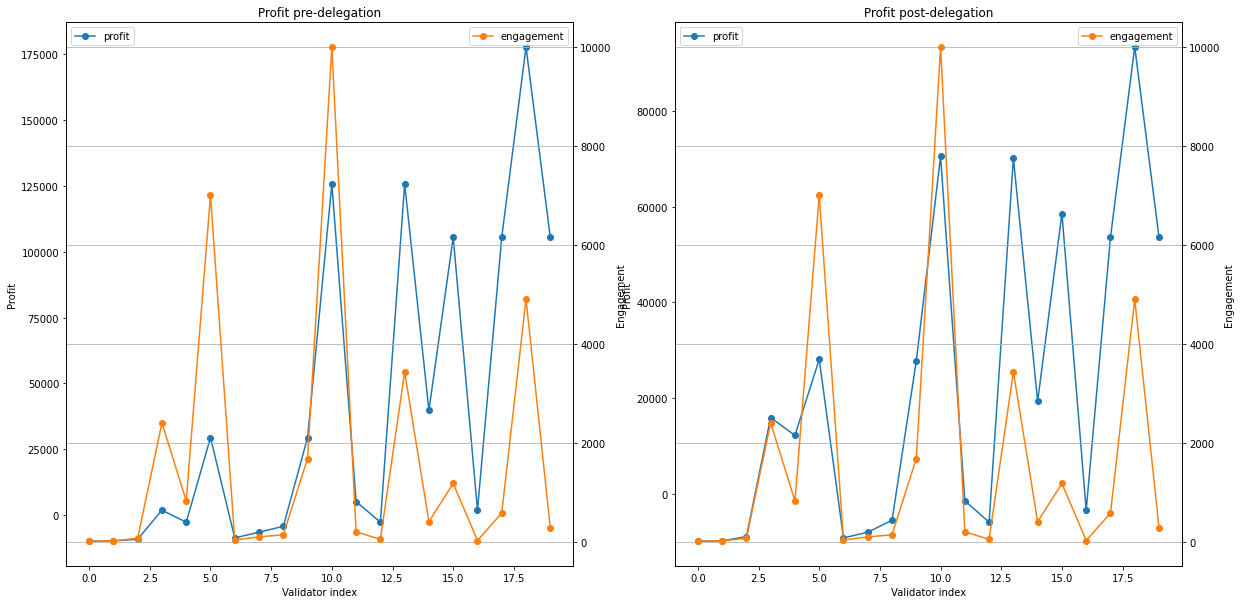

In [28]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('Profit pre-delegation')
plt.xlabel('Validator index')
plt.ylabel('Profit')
plt.plot(profits_pre, marker='o', label="profit")
plt.legend(loc=2)
plt.twinx()
plt.ylabel('Engagement')
plt.plot(engagements, marker='o', color=default_alt_color, label="engagement")
plt.legend(loc=0)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Profit post-delegation')
plt.xlabel('Validator index')
plt.ylabel('Profit')
plt.plot(profits_post, marker='o', label="profit")
plt.legend(loc=2)
plt.twinx()
plt.ylabel('Engagement')
plt.plot(engagements, marker='o', color=default_alt_color, label="engagement")
plt.legend()
plt.grid()

In [29]:
gini_coefficient_voting_weights_pre = calculate_gini_coefficient(voting_weights_pre)
gini_coefficient_voting_weights_post = calculate_gini_coefficient(voting_weights_post)
gini_coefficient_profits_pre = calculate_gini_coefficient(profits_pre)
gini_coefficient_profits_post = calculate_gini_coefficient(profits_post)

print(f'Gini coefficient for voting weights pre-delegation: %f' % gini_coefficient_voting_weights_pre)
print(f'Gini coefficient for voting weights post-delegation: %f' % gini_coefficient_voting_weights_post)
print(f'Gini coefficient for profits pre-delegation: %f' % gini_coefficient_profits_pre)
print(f'Gini coefficient for profits post-delegation: %f' % gini_coefficient_profits_post)

Gini coefficient for voting weights pre-delegation: 0.607067
Gini coefficient for voting weights post-delegation: 0.487189
Gini coefficient for profits pre-delegation: 0.758834
Gini coefficient for profits post-delegation: 0.802565


In [30]:
delegators_post = raw_result[-1]['delegators']

n_staking_delegators = len([delegator for delegator in delegators_post if delegator['validator'] is not None])
percent_staking_delegators = n_staking_delegators * 100 / n_delegators

print(f'Delegators staking: %f%%' % percent_staking_delegators)

Delegators staking: 54.400000%


## Conclusions

- Yield-seeking delegators push voting weights in the direction of more equality.
- Yield-seeking delegators make profits slightly less equal across validators.
- Most validators have lower profits after delegation. High-stake, low-engagement validators lose the most profit, and the biggest winners are validators with very low stake but high engagement.